In [62]:
import pandas as pd 

data = pd.read_csv("../datasets/attribute_set/train_val_data_fine_grained_all.csv", index_col=0) 

In [63]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 0 to 1999
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   paths            16000 non-null  object
 1   floral           16000 non-null  int64 
 2   graphic          16000 non-null  int64 
 3   striped          16000 non-null  int64 
 4   embroidered      16000 non-null  int64 
 5   pleated          16000 non-null  int64 
 6   solid            16000 non-null  int64 
 7   lattice          16000 non-null  int64 
 8   long_sleeve      16000 non-null  int64 
 9   short_sleeve     16000 non-null  int64 
 10  sleeveless       16000 non-null  int64 
 11  maxi_length      16000 non-null  int64 
 12  mini_length      16000 non-null  int64 
 13  no_dress         16000 non-null  int64 
 14  crew_neckline    16000 non-null  int64 
 15  v_neckline       16000 non-null  int64 
 16  square_neckline  16000 non-null  int64 
 17  no_neckline      16000 non-null 

In [64]:
data.head() 

,paths,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,short_sleeve,...,no_neckline,denim,chiffon,cotton,leather,faux,knit,tight,loose,conventional
0,../datasets/big_ds/img-001/img/Sweet_Crochet_B...,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
1,../datasets/big_ds/img-001/img/Classic_Pencil_...,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0
2,../datasets/big_ds/img-001/img/Strapless_Diamo...,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,../datasets/big_ds/img-001/img/Mid-Rise_-_Acid...,0,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,1,0,0
4,../datasets/big_ds/img-001/img/Zippered_Single...,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1


In [65]:
data = data.loc[:, [
    "paths",
    "floral", 
    "graphic" ,
    "striped",
    "embroidered",
    "solid",
    "lattice",
    "denim",
    "chiffon",
    "cotton",
    "leather",
    "faux",
    "knit",
    "tight",
    "loose"
]]

In [66]:
data.columns = [
    "paths",
    "cicekli", 
    "baskili", 
    "duz-cizgi",
    "islemeli", 
    "solid", 
    "kafes",
    "denim",
    "sifon", 
    "pamuk", 
    "deri", 
    "kurk", 
    "orme", 
    "dar",
    "bol-gevsek" 
]

In [67]:
DATA_SIZE = data.shape[0]
TRAIN_SIZE = int(0.70 * DATA_SIZE)
TRAIN_SIZE 

11200

# Shuffle Training Data 

In [68]:
trainig_data = data.iloc[:TRAIN_SIZE, :].sample(frac=1, random_state=42).reset_index(drop=True)
val_data = data.iloc[TRAIN_SIZE:, :].sample(frac=1, random_state=42).reset_index(drop=True)
trainig_data.shape, val_data.shape, data.shape 

((11200, 15), (4800, 15), (16000, 15))

In [69]:
trainig_data.head() 

,paths,cicekli,baskili,duz-cizgi,islemeli,solid,kafes,denim,sifon,pamuk,deri,kurk,orme,dar,bol-gevsek
0,../datasets/big_ds/img-001/img/Strappy_V-Back_...,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,../datasets/big_ds/img-001/img/Sheer_Lace_Dres...,0,0,0,1,0,0,0,1,0,0,0,0,1,0
2,../datasets/big_ds/img-001/img/Tie-Dye_Cami_Ro...,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,../datasets/big_ds/img-001/img/Cuffed_Tee_Shir...,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,../datasets/big_ds/img-001/img/Hooded_Stripe_D...,0,0,1,0,0,0,0,0,1,0,0,0,0,0


# Create Keras Data Generators 

In [70]:
X_train = trainig_data.iloc[:, 0] 
y_train = trainig_data.iloc[:, 1:]

X_test = val_data.iloc[:, 0] 
y_test = val_data.iloc[:, 1:] 

In [71]:
merged_all_classes = [] 
for idx, row in y_train.iterrows():
    merged_all_classes.append([col for col, val in row.items() if val == 1])

y_train = pd.Series(merged_all_classes, index=y_train.index, name="labels") 

merged_all_classes = [] 
for idx, row in y_test.iterrows():
    merged_all_classes.append([col for col, val in row.items() if val == 1])

y_test = pd.Series(merged_all_classes, index=y_test.index, name="labels") 

In [72]:
train_data_flow_df = pd.concat([
    X_train, 
    y_train
], axis=1)

test_data_flow_df = pd.concat([
    X_test, 
    y_test
], axis=1)

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_gen = ImageDataGenerator() 
test_gen = ImageDataGenerator()

In [74]:
train = train_gen.flow_from_dataframe(
    dataframe=train_data_flow_df, 
    directory="", 
    x_col="paths", 
    y_col="labels", 
    seed=42, 
    class_mode='categorical', 
    target_size=(224, 224))

test = test_gen.flow_from_dataframe(
    dataframe=test_data_flow_df, 
    directory="", 
    x_col="paths", 
    y_col="labels", 
    seed=42, 
    class_mode='categorical', 
    target_size=(224, 224))

Found 11200 validated image filenames belonging to 14 classes.
Found 4800 validated image filenames belonging to 14 classes.


# Prepare Data Pipeline by using tf.data 

### Prepare Data Pipeline 

- **batch**(): Combines consecutive elements of this dataset into batches.
- **cache**(): Caches the elements in this dataset. he first time the dataset is iterated over, its elements will be cached either in the specified file or in memory.Subsequent iterations will use the cached data.
- **prefetch**(): Creates a Dataset that prefetches elements from this dataset. Most dataset input pipelines should end with a call to *prefetch*. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.
 

# Model 1:Fine Grained VGG16 

In [75]:
IMG_WIDTH = 224 
IMG_HEIGHT = 224 
nr_of_classes = 14 

In [76]:
from tensorflow import keras 
import tensorflow as tf 

base_model = keras.applications.VGG16(
    weights="imagenet", # load weights pre-trained on ImageNet. 
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), # VGG16 expects min 32 x 32 
    include_top = False # do not include output layer of the image net vgg 
)
base_model.trainable = False 

In [77]:
inputs = keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT,3))
x = tf.cast(inputs, tf.float32)
x = tf.keras.applications.vgg16.preprocess_input(x)   
x = base_model(x) 
x = keras.layers.GlobalAveragePooling2D()(x) 

initializer = tf.keras.initializers.GlorotUniform(seed=42) 
activation = tf.keras.activations.sigmoid  

outputs = keras.layers.Dense(nr_of_classes,
                             kernel_initializer=initializer, 
                             activation=activation)(x) 

model_1 = keras.Model(inputs, outputs) 

In [78]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')
]


model_1.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
              metrics=METRICS)

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) 
checkpoint_path = "checkpoints/attribute_preds_based_14v2/checkpoint-{epoch:01d}.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         verbose=1)

In [21]:
history_model_1 = model_1.fit(train, 
                            epochs=10,
                            validation_data =test,
                            callbacks=[early_stopping, checkpoint_callback]
                            )

Epoch 1/10
350/350 [==============================] - ETA: 0s - loss: 0.4446 - tp: 12458.0000 - fp: 9480.0000 - tn: 122944.0000 - fn: 11918.0000 - accuracy: 0.8635 - precision: 0.5679 - recall: 0.5111
Epoch 1: val_loss improved from inf to 0.31733, saving model to checkpoints/attribute_preds_based_14v2\checkpoint-1.ckpt
350/350 [==============================] - 1805s 5s/step - loss: 0.4446 - tp: 12458.0000 - fp: 9480.0000 - tn: 122944.0000 - fn: 11918.0000 - accuracy: 0.8635 - precision: 0.5679 - recall: 0.5111 - val_loss: 0.3173 - val_tp: 6197.0000 - val_fp: 3217.0000 - val_tn: 53531.0000 - val_fn: 4255.0000 - val_accuracy: 0.8888 - val_precision: 0.6583 - val_recall: 0.5929
Epoch 2/10
350/350 [==============================] - ETA: 0s - loss: 0.2804 - tp: 14736.0000 - fp: 6340.0000 - tn: 126084.0000 - fn: 9640.0000 - accuracy: 0.8981 - precision: 0.6992 - recall: 0.6045
Epoch 2: val_loss improved from 0.31733 to 0.27781, saving model to checkpoints/attribute_preds_based_14v2\checkpo

In [ ]:
# model_1.save("../trained_models/model_1_fine_grained_vgg.h5") 

In [19]:
model_1.load_weights("checkpoints/attribute_preds_based_14v2/checkpoint-7.ckpt")

In [23]:
model_1.evaluate(test) 

150/150 [==============================] - 660s 4s/step - loss: 0.2487 - tp: 6460.0000 - fp: 2486.0000 - tn: 54262.0000 - fn: 3992.0000 - accuracy: 0.9036 - precision: 0.7221 - recall: 0.6181


[0.248697891831398,
 6460.0,
 2486.0,
 54262.0,
 3992.0,
 0.9036011695861816,
 0.7221104502677917,
 0.6180635094642639]

In [24]:
model_1.evaluate(train)

350/350 [==============================] - 2051s 6s/step - loss: 0.2059 - tp: 16093.0000 - fp: 4587.0000 - tn: 127837.0000 - fn: 8283.0000 - accuracy: 0.9179 - precision: 0.7782 - recall: 0.6602


[0.20588621497154236,
 16093.0,
 4587.0,
 127837.0,
 8283.0,
 0.9179209470748901,
 0.7781915068626404,
 0.6601985692977905]

# Model 2: Efficient Net 

In [21]:
efficient_net = tf.keras.applications.EfficientNetB0(include_top=False)
efficient_net.trainable = False

In [22]:
inputs = keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT,3)) 
x = efficient_net(inputs) 
x = keras.layers.GlobalAveragePooling2D()(x) 

initializer = tf.keras.initializers.GlorotUniform(seed=42) 
activation = tf.keras.activations.sigmoid  

outputs = keras.layers.Dense(nr_of_classes,
                             kernel_initializer=initializer, 
                             activation=activation)(x) 

model_2 = keras.Model(inputs, outputs) 

In [23]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')
]

In [24]:
model_2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
              metrics=METRICS)

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5) 
checkpoint_path = "checkpoints/attr_pred_based_14_effnet_v2/checkpoint-{epoch:01d}.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         verbose=1)

In [27]:
history_model_2 = model_2.fit(train, 
        validation_data =test,
        epochs=10,
        callbacks=[early_stopping, checkpoint_callback])

Epoch 1/10
350/350 [==============================] - ETA: 0s - loss: 0.2688 - tp: 13015.0000 - fp: 4890.0000 - tn: 127534.0000 - fn: 11361.0000 - accuracy: 0.8964 - precision: 0.7269 - recall: 0.5339
Epoch 1: saving model to checkpoints/attr_pred_based_14_effnet_v2\checkpoint-1.ckpt
350/350 [==============================] - 750s 2s/step - loss: 0.2688 - tp: 13015.0000 - fp: 4890.0000 - tn: 127534.0000 - fn: 11361.0000 - accuracy: 0.8964 - precision: 0.7269 - recall: 0.5339 - val_loss: 0.2346 - val_tp: 6319.0000 - val_fp: 2069.0000 - val_tn: 54679.0000 - val_fn: 4133.0000 - val_accuracy: 0.9077 - val_precision: 0.7533 - val_recall: 0.6046
Epoch 2/10
350/350 [==============================] - ETA: 0s - loss: 0.2246 - tp: 14944.0000 - fp: 4518.0000 - tn: 127906.0000 - fn: 9432.0000 - accuracy: 0.9110 - precision: 0.7679 - recall: 0.6131
Epoch 2: saving model to checkpoints/attr_pred_based_14_effnet_v2\checkpoint-2.ckpt
350/350 [==============================] - 1022s 3s/step - loss: 0.2

In [82]:
# model_2.save("../trained_models/model_2_efficientnet_SHUFFLEDdata_fine_grained_vgg.h5") 

In [88]:
# from helpers import save_with_pickle
# save_with_pickle("../trained_models/model_2_efficientnet_SHUFFLEDdata_fine_grained_vgg_HISTORY.pickle", history_model_2.history)

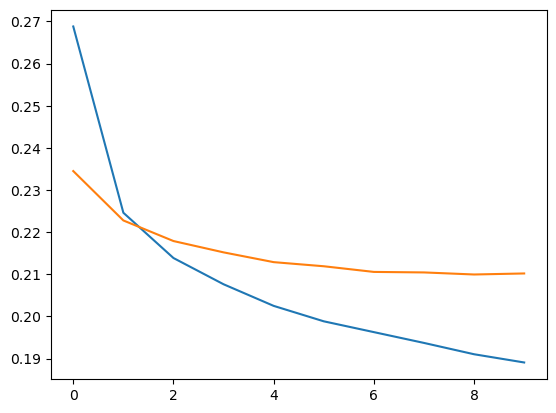

In [36]:
import numpy as np 
import matplotlib.pyplot as plt 

loss = np.array(history_model_2.history["loss"], dtype=np.float16) 
val_loss = np.array(history_model_2.history["val_loss"], dtype=np.float16) 

plt.plot(loss, label="loss") 
plt.plot(val_loss, label="val_loss")
plt.show()

In [38]:
pd.DataFrame(history_model_2.history)

,loss,tp,fp,tn,fn,accuracy,precision,recall,val_loss,val_tp,val_fp,val_tn,val_fn,val_accuracy,val_precision,val_recall
0,0.268826,13015.0,4890.0,127534.0,11361.0,0.896358,0.726892,0.533927,0.234556,6319.0,2069.0,54679.0,4133.0,0.907708,0.753338,0.604573
1,0.224611,14944.0,4518.0,127906.0,9432.0,0.911033,0.767855,0.613062,0.222806,6486.0,1931.0,54817.0,3966.0,0.912247,0.770583,0.620551
2,0.213906,15445.0,4464.0,127960.0,8931.0,0.914573,0.775780,0.633615,0.217860,6556.0,1960.0,54788.0,3896.0,0.912857,0.769845,0.627248
3,0.207700,15723.0,4386.0,128038.0,8653.0,0.916843,0.781889,0.645020,0.215206,6684.0,1974.0,54774.0,3768.0,0.914554,0.772003,0.639495
4,0.202487,15972.0,4408.0,128016.0,8404.0,0.918291,0.783710,0.655235,0.212923,6788.0,2027.0,54721.0,3664.0,0.915313,0.770051,0.649445
5,0.198844,16135.0,4301.0,128123.0,8241.0,0.920013,0.789538,0.661922,0.211873,6915.0,2122.0,54626.0,3537.0,0.915789,0.765188,0.661596
6,0.196245,16270.0,4352.0,128072.0,8106.0,0.920548,0.788963,0.667460,0.210603,6754.0,1944.0,54804.0,3698.0,0.916042,0.776500,0.646192
7,0.193758,16339.0,4247.0,128177.0,8037.0,0.921658,0.793695,0.670290,0.210416,6892.0,2029.0,54719.0,3560.0,0.916830,0.772559,0.659395
8,0.190999,16438.0,4238.0,128186.0,7938.0,0.922347,0.795028,0.674352,0.209912,6905.0,2068.0,54680.0,3547.0,0.916443,0.769531,0.660639
9,0.189034,16555.0,4236.0,128188.0,7821.0,0.923106,0.796258,0.679152,0.210175,7035.0,2154.0,54594.0,3417.0,0.917098,0.765589,0.673077


### Model 2 Fine Tune

In [42]:
efficient_net.trainable = True  

for layer in efficient_net.layers[:-15]:
    layer.trainable = False 

model_2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=METRICS)

In [43]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5) 
checkpoint_path = "checkpoints/attr_pred_based_14_effnet_v2/checkpoint-{epoch:01d}.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         verbose=1)

In [44]:
history_model_2_fine = model_2.fit(train, 
        validation_data =test,
        epochs=20, 
        initial_epoch=history_model_2.epoch[-1], # start from previous last epoch 
        callbacks=[checkpoint_callback])

Epoch 10/20
350/350 [==============================] - ETA: 0s - loss: 0.2104 - tp: 23131.0000 - fp: 7121.0000 - tn: 182051.0000 - fn: 11697.0000 - accuracy: 0.9160 - precision: 0.7646 - recall: 0.6641
Epoch 10: saving model to checkpoints/attr_pred_based_14_effnet_v2\checkpoint-10.ckpt
350/350 [==============================] - 1557s 4s/step - loss: 0.2104 - tp: 23131.0000 - fp: 7121.0000 - tn: 182051.0000 - fn: 11697.0000 - accuracy: 0.9160 - precision: 0.7646 - recall: 0.6641 - val_loss: 0.2148 - val_tp: 7293.0000 - val_fp: 2237.0000 - val_tn: 54511.0000 - val_fn: 3159.0000 - val_accuracy: 0.9197 - val_precision: 0.7653 - val_recall: 0.6978
Epoch 11/20
350/350 [==============================] - ETA: 0s - loss: 0.1739 - tp: 17386.0000 - fp: 4169.0000 - tn: 128255.0000 - fn: 6990.0000 - accuracy: 0.9288 - precision: 0.8066 - recall: 0.7132
Epoch 11: saving model to checkpoints/attr_pred_based_14_effnet_v2\checkpoint-11.ckpt
350/350 [==============================] - 1588s 5s/step - lo

In [ ]:
# model_2.save("../trained_models/fine_model_2_fine_grained_vgg.h5") 

<AxesSubplot:>

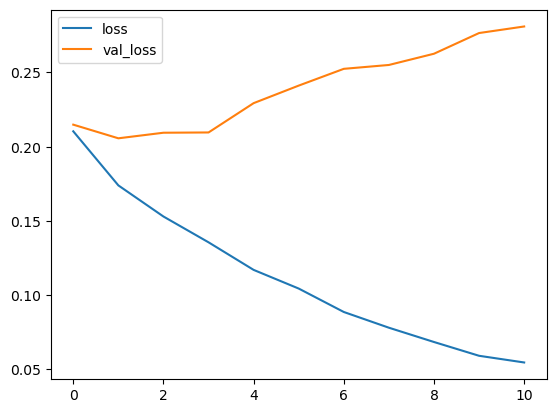

In [48]:
pd.DataFrame(history_model_2_fine.history)[["loss", "val_loss"]].plot()

In [49]:
def compare_historys(original_history, new_history, initial_epochs=10):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """ 
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

<AxesSubplot:>

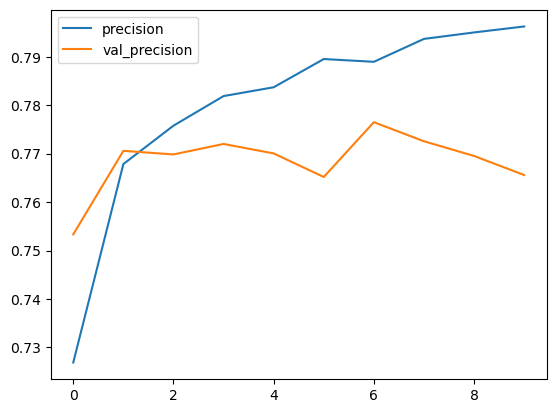

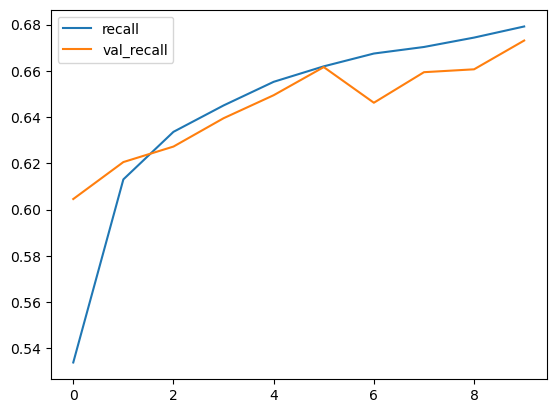

In [55]:
pd.DataFrame(history_model_2.history)[["precision", "val_precision"]].plot()
pd.DataFrame(history_model_2.history)[["recall", "val_recall"]].plot()

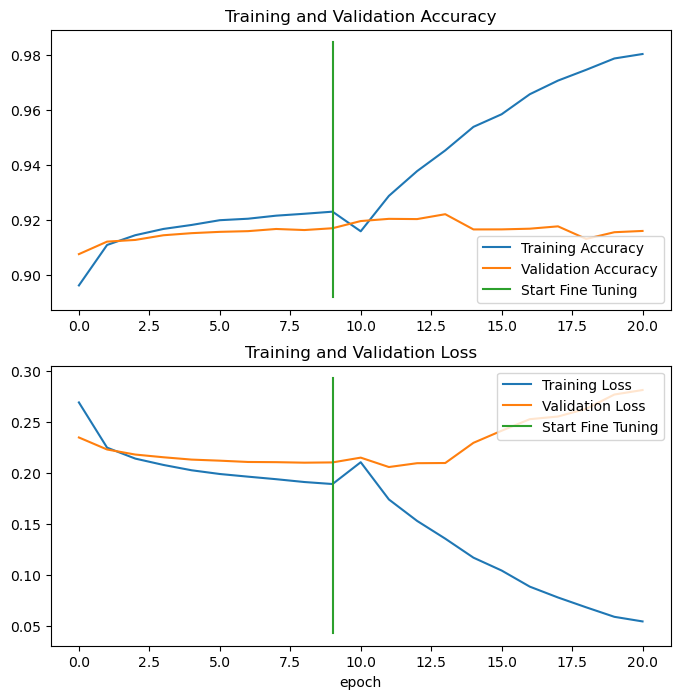

In [50]:
compare_historys(history_model_2, history_model_2_fine)

# Model 3: EfficientNet with Data Augmentation 

In [51]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation_model = Sequential([
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2), 
    preprocessing.RandomZoom(0.2)
], name="data_augmentation") 

In [52]:
nr_of_classes

14

In [56]:
from tensorflow import keras 

efficient_net_model_3 = tf.keras.applications.EfficientNetB0(include_top=False)
efficient_net_model_3.trainable = False 

inputs = keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT,3)) 
x = data_augmentation_model(inputs)
x = efficient_net_model_3(x, training=False) 
x = keras.layers.GlobalAveragePooling2D()(x) 

initializer = tf.keras.initializers.GlorotUniform(seed=42) 
activation = tf.keras.activations.sigmoid  

outputs = keras.layers.Dense(nr_of_classes,
                             kernel_initializer=initializer, 
                             activation=activation)(x) 

model_3 = keras.Model(inputs, outputs) 

In [57]:
model_3.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=METRICS)

In [58]:
checkpoint_path = "checkpoints/model_3_fine_grained_14_attr/checkpoint{epoch:01d}.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         verbose=1)

In [59]:
history_model_3 = model_3.fit(train, 
        validation_data =test,
        epochs=10, 
        callbacks=[checkpoint_callback])

Epoch 1/10
350/350 [==============================] - ETA: 0s - loss: 0.2687 - tp: 20346.0000 - fp: 7405.0000 - tn: 181767.0000 - fn: 14482.0000 - accuracy: 0.9023 - precision: 0.7332 - recall: 0.5842
Epoch 1: saving model to checkpoints/model_3_fine_grained_14_attr\checkpoint1.ckpt
350/350 [==============================] - 2568s 7s/step - loss: 0.2687 - tp: 20346.0000 - fp: 7405.0000 - tn: 181767.0000 - fn: 14482.0000 - accuracy: 0.9023 - precision: 0.7332 - recall: 0.5842 - val_loss: 0.2378 - val_tp: 5974.0000 - val_fp: 1807.0000 - val_tn: 54941.0000 - val_fn: 4478.0000 - val_accuracy: 0.9065 - val_precision: 0.7678 - val_recall: 0.5716
Epoch 2/10
350/350 [==============================] - ETA: 0s - loss: 0.2244 - tp: 14907.0000 - fp: 4504.0000 - tn: 127920.0000 - fn: 9469.0000 - accuracy: 0.9109 - precision: 0.7680 - recall: 0.6115
Epoch 2: saving model to checkpoints/model_3_fine_grained_14_attr\checkpoint2.ckpt
350/350 [==============================] - 2308s 7s/step - loss: 0.22

In [ ]:
# model_3.save("../trained_models/model_3_fine_grained.h5") 

<AxesSubplot:>

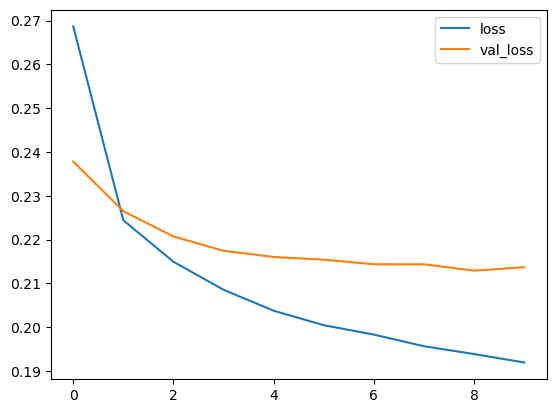

In [62]:
pd.DataFrame(history_model_3.history)[["loss", "val_loss"]].plot() 

In [65]:
pd.DataFrame(history_model_3.history)[["recall", "val_recall"]]

,recall,val_recall
0,0.584185,0.571565
1,0.611544,0.604382
2,0.631441,0.626005
3,0.642476,0.641408
4,0.652855,0.642365
5,0.657737,0.630980
6,0.661388,0.655281
7,0.666721,0.662840
8,0.673244,0.635572
9,0.676936,0.667336


In [70]:
efficient_net_model_3.trainable = True  

for layer in efficient_net_model_3.layers[:-15]:
    layer.trainable = False 

model_3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=METRICS)
 
history_model_3_fine = model_3.fit(train, 
                                    validation_data =test,
                                    epochs=20, 
                                    initial_epoch=history_model_3.epoch[-1], # start from previous last epoch 
                                    callbacks=[checkpoint_callback])

Epoch 10/20
350/350 [==============================] - ETA: 0s - loss: 0.2954 - tp: 28866.0000 - fp: 6286.0000 - tn: 215056.0000 - fn: 11872.0000 - accuracy: 0.9307 - precision: 0.8212 - recall: 0.7086
Epoch 10: saving model to checkpoints/model_3_fine_grained_14_attr\checkpoint10.ckpt
350/350 [==============================] - 3187s 9s/step - loss: 0.2954 - tp: 28866.0000 - fp: 6286.0000 - tn: 215056.0000 - fn: 11872.0000 - accuracy: 0.9307 - precision: 0.8212 - recall: 0.7086 - val_loss: 0.2560 - val_tp: 5758.0000 - val_fp: 1984.0000 - val_tn: 54764.0000 - val_fn: 4694.0000 - val_accuracy: 0.9006 - val_precision: 0.7437 - val_recall: 0.5509
Epoch 11/20
350/350 [==============================] - ETA: 0s - loss: 1.1621 - tp: 13541.0000 - fp: 6086.0000 - tn: 126338.0000 - fn: 10835.0000 - accuracy: 0.8921 - precision: 0.6899 - recall: 0.5555
Epoch 11: saving model to checkpoints/model_3_fine_grained_14_attr\checkpoint11.ckpt
350/350 [==============================] - 2917s 8s/step - los

# Model 4: ResNet50V2 

In [71]:
resnet50_v2 = tf.keras.applications.ResNet50V2(
    include_top=False, 
    weights="imagenet"
)
resnet50_v2.trainable = False 

In [72]:
data_augmentation_model_r = Sequential([
                                        preprocessing.RandomHeight(0.2),
                                        preprocessing.RandomWidth(0.2), 
                                        preprocessing.RandomZoom(0.2)
                                    ], name="data_augmentation") 

In [73]:
inputs = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT,3)) 
x = data_augmentation_model_r(inputs)
x = resnet50_v2(x)
x = keras.layers.GlobalAveragePooling2D()(x) 
outputs = keras.layers.Dense(nr_of_classes, activation=tf.keras.activations.sigmoid)(x) 
model_4 = keras.Model(inputs, outputs) 

In [74]:
model_4.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=METRICS)
checkpoint_path = "checkpoints/model_4_fine_grained_14_attr/checkpoint{epoch:01d}.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         verbose=1)
history_model_4 = model_4.fit(train, 
        validation_data =test,
        epochs=10, 
        callbacks=[checkpoint_callback])

Epoch 1/10
350/350 [==============================] - ETA: 0s - loss: 27.0636 - tp: 13526.0000 - fp: 15730.0000 - tn: 173442.0000 - fn: 21302.0000 - accuracy: 0.8347 - precision: 0.4623 - recall: 0.3884
Epoch 1: saving model to checkpoints/model_4_fine_grained_14_attr\checkpoint1.ckpt
350/350 [==============================] - 2858s 8s/step - loss: 27.0636 - tp: 13526.0000 - fp: 15730.0000 - tn: 173442.0000 - fn: 21302.0000 - accuracy: 0.8347 - precision: 0.4623 - recall: 0.3884 - val_loss: 22.0769 - val_tp: 2819.0000 - val_fp: 8654.0000 - val_tn: 48094.0000 - val_fn: 7633.0000 - val_accuracy: 0.7576 - val_precision: 0.2457 - val_recall: 0.2697
Epoch 2/10
350/350 [==============================] - ETA: 0s - loss: 20.8373 - tp: 10618.0000 - fp: 13853.0000 - tn: 118571.0000 - fn: 13758.0000 - accuracy: 0.8239 - precision: 0.4339 - recall: 0.4356
Epoch 2: saving model to checkpoints/model_4_fine_grained_14_attr\checkpoint2.ckpt
350/350 [==============================] - 2858s 8s/step - lo

# Model 5: Grid Search on Efficient Net

In [90]:
from sklearn.model_selection import ParameterGrid 

parameters = {
    'batch_size': [32, 48, 64],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'freeze': [False, True]
}

list(ParameterGrid(parameters))

[{'batch_size': 32, 'freeze': False, 'learning_rate': 0.001},
 {'batch_size': 32, 'freeze': False, 'learning_rate': 0.01},
 {'batch_size': 32, 'freeze': False, 'learning_rate': 0.1},
 {'batch_size': 32, 'freeze': False, 'learning_rate': 0.2},
 {'batch_size': 32, 'freeze': False, 'learning_rate': 0.3},
 {'batch_size': 32, 'freeze': True, 'learning_rate': 0.001},
 {'batch_size': 32, 'freeze': True, 'learning_rate': 0.01},
 {'batch_size': 32, 'freeze': True, 'learning_rate': 0.1},
 {'batch_size': 32, 'freeze': True, 'learning_rate': 0.2},
 {'batch_size': 32, 'freeze': True, 'learning_rate': 0.3},
 {'batch_size': 48, 'freeze': False, 'learning_rate': 0.001},
 {'batch_size': 48, 'freeze': False, 'learning_rate': 0.01},
 {'batch_size': 48, 'freeze': False, 'learning_rate': 0.1},
 {'batch_size': 48, 'freeze': False, 'learning_rate': 0.2},
 {'batch_size': 48, 'freeze': False, 'learning_rate': 0.3},
 {'batch_size': 48, 'freeze': True, 'learning_rate': 0.001},
 {'batch_size': 48, 'freeze': True,

In [82]:
def get_generator(batch_size:int, random_state: int): 
    train_gen_grid = ImageDataGenerator() 
    test_gen_grid = ImageDataGenerator()

    train_grid = train_gen_grid.flow_from_dataframe(
        dataframe=train_data_flow_df, 
        directory="", 
        x_col="paths", 
        y_col="labels", 
        seed=random_state, 
        class_mode='categorical', 
        batch_size=batch_size,
        target_size=(224, 224))

    test_grid = test_gen_grid.flow_from_dataframe(
        dataframe=test_data_flow_df, 
        directory="", 
        x_col="paths", 
        y_col="labels", 
        seed=random_state, 
        class_mode='categorical',
        batch_size=batch_size, 
        target_size=(224, 224))
    
    return train_grid, test_grid

In [88]:
def create_model(learning_rate, freeze: bool): 
    efficient_net = tf.keras.applications.EfficientNetB0(include_top=False)
    efficient_net.trainable = False

    if freeze: 
        efficient_net.trainable = True 
        for layer in efficient_net.layers[:-15]:
            layer.trainable = False 

    inputs = keras.Input(shape=(224,224,3)) 
    x = efficient_net(inputs) 
    x = keras.layers.GlobalAveragePooling2D()(x) 
    initializer = tf.keras.initializers.GlorotUniform(seed=42) 
    activation = tf.keras.activations.sigmoid  
    outputs = keras.layers.Dense(nr_of_classes,
                                kernel_initializer=initializer, 
                                activation=activation)(x) 

    model = keras.Model(inputs, outputs) 
    METRICS = [
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
                metrics=METRICS)   
    
    return model

In [92]:
def try_fit(parameters_list: list): 
    historys = [] 
    for parameter_set in parameters_list:
        gen_train, gen_test = get_generator(parameter_set["batch_size"], random_state=64)
        model = create_model(learning_rate=parameter_set["learning_rate"], freeze=parameter_set["freeze"]) 
        history = model.fit(gen_train, validation_data=gen_test, epochs=30) 
        historys.append({
            "model_parameters": parameters_list, 
            "history": history
        })
    
    return history 

# Evaluate Models 

### Evaluation of Model 1

In [45]:
model_1_loaded = tf.keras.models.load_model("../trained_models/model_1_fine_grained_vgg.h5")

In [46]:
model_1_loaded.layers

1/1 [==============================] - 0s 280ms/step
floral             0.0
graphic            0.0
striped            0.0
embroidered        0.0
pleated            0.0
solid              1.0
lattice            0.0
long_sleeve        0.0
short_sleeve       0.0
sleeveless         1.0
maxi_length        0.0
mini_length        0.0
no_dress           1.0
crew_neckline      0.0
v_neckline         0.0
square_neckline    0.0
no_neckline        1.0
denim              0.0
chiffon            0.0
cotton             1.0
leather            0.0
faux               0.0
knit               0.0
tight              0.0
loose              0.0
conventional       1.0
dtype: float32


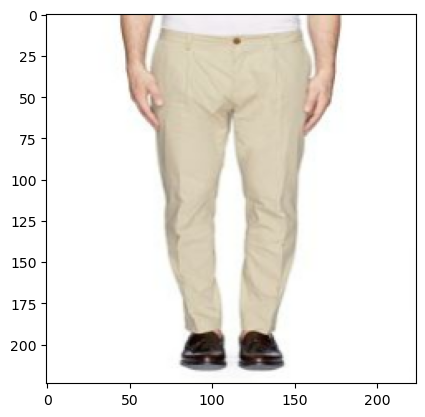

In [64]:
from helpers import show_image, evaluate_img

print(evaluate_img(fnames[500], model=model_1_loaded, columns=list(data.columns[1:]), threshold=0.5))
show_image(fnames[500])

1/1 [==============================] - 0s 146ms/step
floral             0.0
graphic            0.0
striped            0.0
embroidered        0.0
pleated            0.0
solid              0.0
lattice            1.0
long_sleeve        1.0
short_sleeve       0.0
sleeveless         0.0
maxi_length        0.0
mini_length        0.0
no_dress           1.0
crew_neckline      1.0
v_neckline         0.0
square_neckline    0.0
no_neckline        0.0
denim              0.0
chiffon            0.0
cotton             1.0
leather            0.0
faux               0.0
knit               0.0
tight              0.0
loose              0.0
conventional       1.0
dtype: float32


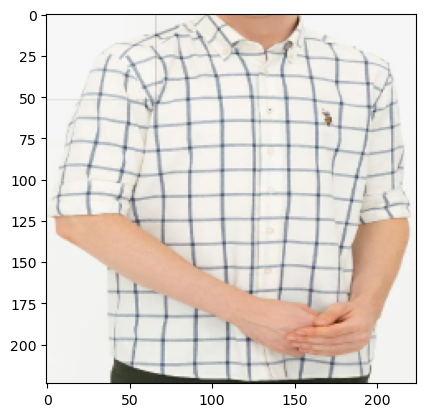

In [28]:
path = "../datasets/demos/uspa_sq.PNG"
print(evaluate_img(path, model=model_1_loaded, columns=list(data.columns[1:]), threshold=0.5))
show_image(path)

1/1 [==============================] - 0s 167ms/step
floral             0.0
graphic            0.0
striped            0.0
embroidered        0.0
pleated            0.0
solid              0.0
lattice            1.0
long_sleeve        1.0
short_sleeve       0.0
sleeveless         0.0
maxi_length        0.0
mini_length        0.0
no_dress           1.0
crew_neckline      0.0
v_neckline         0.0
square_neckline    0.0
no_neckline        0.0
denim              0.0
chiffon            0.0
cotton             1.0
leather            0.0
faux               0.0
knit               0.0
tight              0.0
loose              0.0
conventional       1.0
dtype: float32


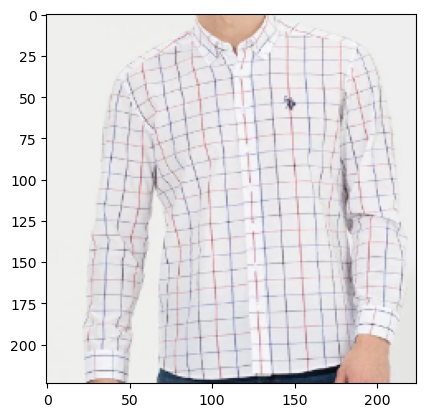

In [29]:
path = "../datasets/demos/uspa_sq2.PNG"
print(evaluate_img(path, model=model_1_loaded, columns=list(data.columns[1:]), threshold=0.5))
show_image(path)

1/1 [==============================] - 0s 384ms/step
floral             1.0
graphic            0.0
striped            0.0
embroidered        0.0
pleated            0.0
solid              0.0
lattice            0.0
long_sleeve        1.0
short_sleeve       0.0
sleeveless         0.0
maxi_length        0.0
mini_length        0.0
no_dress           1.0
crew_neckline      1.0
v_neckline         0.0
square_neckline    0.0
no_neckline        0.0
denim              0.0
chiffon            0.0
cotton             0.0
leather            0.0
faux               0.0
knit               0.0
tight              0.0
loose              0.0
conventional       1.0
dtype: float32


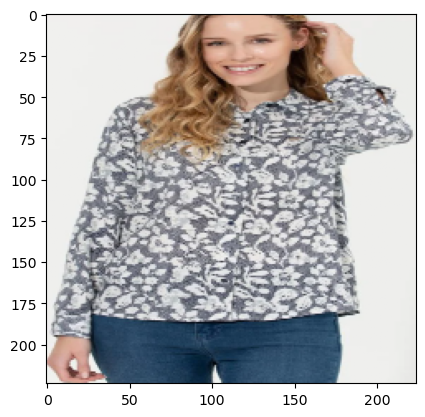

In [32]:
path = "../datasets/demos/floral.PNG"
print(evaluate_img(path, model=model_1_loaded, columns=list(data.columns[1:]), threshold=0.5))
show_image(path)

1/1 [==============================] - 0s 328ms/step
floral             0.0
graphic            0.0
striped            0.0
embroidered        0.0
pleated            0.0
solid              0.0
lattice            0.0
long_sleeve        1.0
short_sleeve       0.0
sleeveless         0.0
maxi_length        0.0
mini_length        0.0
no_dress           1.0
crew_neckline      0.0
v_neckline         0.0
square_neckline    0.0
no_neckline        0.0
denim              0.0
chiffon            0.0
cotton             0.0
leather            0.0
faux               0.0
knit               1.0
tight              0.0
loose              0.0
conventional       1.0
dtype: float32


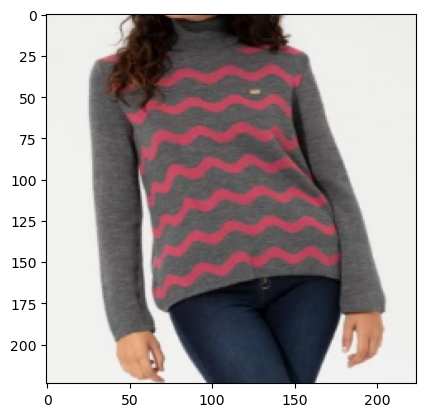

In [33]:
path = "../datasets/demos/stripped_uspa.PNG"
print(evaluate_img(path, model=model_1_loaded, columns=list(data.columns[1:]), threshold=0.5))
show_image(path)

In [47]:
model_1_loaded.evaluate(ds_test_batched.take(1))

1/1 [==============================] - 54s 54s/step - loss: 0.2866 - binary_accuracy: 0.8906


[0.28657177090644836, 0.890625]

In [48]:
first_batch = ds_test_batched.take(1).as_numpy_iterator()

In [49]:
actual_results = next(first_batch)

In [50]:
actual_labels = actual_results[1]
inputs_val = actual_results[0]

In [51]:
predicted_val = model_1_loaded.predict(inputs_val)

1/1 [==============================] - 5s 5s/step


In [52]:
predicted_val[predicted_val > 0.5] = 1 
predicted_val[predicted_val < 0.5 ] = 0 

In [53]:
from sklearn.metrics import accuracy_score

In [54]:
accuracy_score(actual_labels, predicted_val)

0.25

In [61]:
m = tf.keras.metrics.BinaryAccuracy(threshold=0.9)
m.update_state(actual_labels, predicted_val)
m.result().numpy()


0.890625

In [56]:
predicted_val[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [57]:
actual_labels[0]

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1], dtype=int64)

## Evaluation of Model 2 

In [62]:
model_2_loaded = tf.keras.models.load_model("../trained_models/model_2_fine_grained_vgg.h5") 

1/1 [==============================] - 0s 165ms/step
floral             0.0
graphic            0.0
striped            0.0
embroidered        0.0
pleated            0.0
solid              0.0
lattice            1.0
long_sleeve        1.0
short_sleeve       0.0
sleeveless         0.0
maxi_length        0.0
mini_length        0.0
no_dress           1.0
crew_neckline      1.0
v_neckline         0.0
square_neckline    0.0
no_neckline        0.0
denim              0.0
chiffon            0.0
cotton             1.0
leather            0.0
faux               0.0
knit               0.0
tight              0.0
loose              0.0
conventional       1.0
dtype: float32


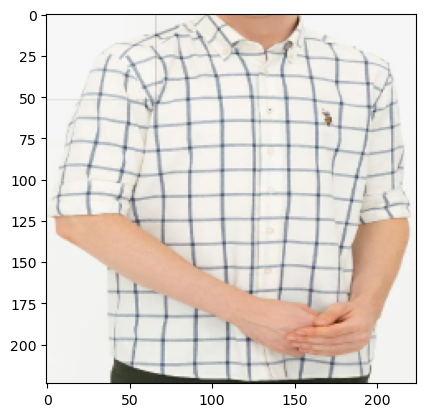

In [65]:
path = "../datasets/demos/uspa_sq.PNG"
print(evaluate_img(path, model=model_1_loaded, columns=list(data.columns[1:]), threshold=0.5))
show_image(path)

1/1 [==============================] - 0s 108ms/step
floral             0.0
graphic            0.0
striped            0.0
embroidered        0.0
pleated            0.0
solid              0.0
lattice            1.0
long_sleeve        1.0
short_sleeve       0.0
sleeveless         0.0
maxi_length        0.0
mini_length        0.0
no_dress           1.0
crew_neckline      0.0
v_neckline         0.0
square_neckline    0.0
no_neckline        0.0
denim              0.0
chiffon            0.0
cotton             1.0
leather            0.0
faux               0.0
knit               0.0
tight              0.0
loose              0.0
conventional       1.0
dtype: float32


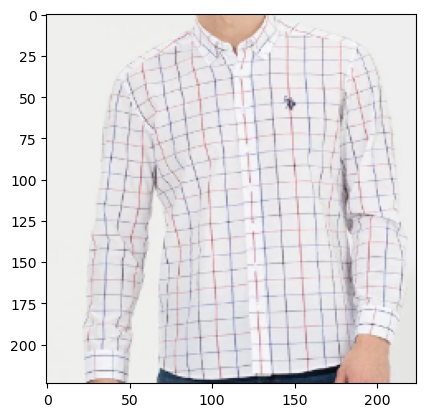

In [66]:
path = "../datasets/demos/uspa_sq2.PNG"
print(evaluate_img(path, model=model_1_loaded, columns=list(data.columns[1:]), threshold=0.5))
show_image(path)

1/1 [==============================] - 0s 166ms/step
floral             1.0
graphic            0.0
striped            0.0
embroidered        0.0
pleated            0.0
solid              0.0
lattice            0.0
long_sleeve        1.0
short_sleeve       0.0
sleeveless         0.0
maxi_length        0.0
mini_length        0.0
no_dress           1.0
crew_neckline      1.0
v_neckline         0.0
square_neckline    0.0
no_neckline        0.0
denim              0.0
chiffon            0.0
cotton             0.0
leather            0.0
faux               0.0
knit               0.0
tight              0.0
loose              0.0
conventional       1.0
dtype: float32


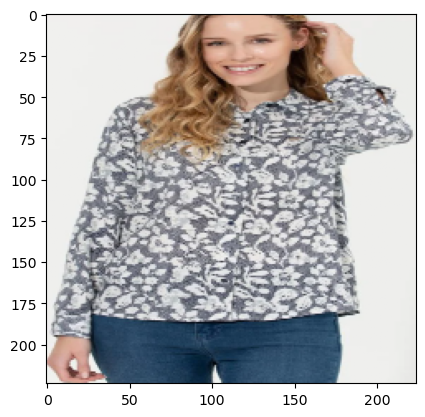

In [67]:
path = "../datasets/demos/floral.PNG"
print(evaluate_img(path, model=model_1_loaded, columns=list(data.columns[1:]), threshold=0.5))
show_image(path)